In [1]:
from pulp import *

In [2]:
# Gather the data from the txt file
vals = []
with open('bakery.txt', 'r') as f:
    for line in f:
            l = line.strip().split()
            vals.append([int(l[j]) for j in range(4)])

In [3]:
# Initialize the problem
prob = LpProblem("Bakery", LpMinimize)

s = LpVariable.dicts("s", range(17), lowBound=0)
z = LpVariable.dicts("z", [(i, j) for i in range(17) for j in range(17)], cat="Binary")

obj = LpVariable("Objective", lowBound=0)
prob += obj


In [4]:
# Initialize the constraints
M = 28000

for i in range(17):
    prob += s[i] >= vals[i][1]
    prob += s[i] + vals[i][3] <= vals[i][2]
    prob += obj >= s[i] + vals[i][3]
    for j in range(17):
        if j > i:
            prob += s[i] + vals[i][3] <= s[j] + M*z[(i, j)]
            prob += s[j] + vals[j][3] <= s[i] + M*(1 - z[(i, j)])


In [5]:
status = prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc /var/folders/f_/v_3n55497xl81517pgtypd8c0000gn/T/d51ce545501748d787d400bd77b830da-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/f_/v_3n55497xl81517pgtypd8c0000gn/T/d51ce545501748d787d400bd77b830da-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 328 COLUMNS
At line 1486 RHS
At line 1810 BOUNDS
At line 1947 ENDATA
Problem MODEL has 323 rows, 154 columns and 884 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16800 - 0.00 seconds
Cgl0003I 9 fixed, 0 tightened bounds, 139 strengthened rows, 2 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 1 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 67 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bo

In [8]:
# Create the return dict
retval = {f"s_{i}":s[i].value() for i in range(17)}

({'s_0': 5400.0,
  's_1': 8400.0,
  's_2': 0.0,
  's_3': 4800.0,
  's_4': 1800.0,
  's_5': 9000.0,
  's_6': 10200.0,
  's_7': 11400.0,
  's_8': 14400.0,
  's_9': 600.0,
  's_10': 17400.0,
  's_11': 20400.0,
  's_12': 15600.0,
  's_13': 18600.0,
  's_14': 12600.0,
  's_15': 6000.0,
  's_16': 2400.0},
 22200.0)

In [9]:
s_reval = dict(sorted(retval.items(), key=lambda item: item[1]))

{'s_2': 0.0,
 's_9': 600.0,
 's_4': 1800.0,
 's_16': 2400.0,
 's_3': 4800.0,
 's_0': 5400.0,
 's_15': 6000.0,
 's_1': 8400.0,
 's_5': 9000.0,
 's_6': 10200.0,
 's_7': 11400.0,
 's_14': 12600.0,
 's_8': 14400.0,
 's_12': 15600.0,
 's_10': 17400.0,
 's_13': 18600.0,
 's_11': 20400.0}

In [10]:
# Create the pandas DataFrame for the plot
for i in range(len(vals)):
    vals[i][0] = f"s_{i}"

df = pd.DataFrame.from_records(vals, columns=['id', 'pre', 'dln', 'bak'])
df['starting_time'] = df['id'].map(lambda x: retval[x]) 
df['end'] = df['starting_time'] + df['bak']
df = df.set_index('id')

,pre,dln,bak,starting_time,end
id,,,,,
s_0,4800,9600,600,5400.0,6000.0
s_1,5400,27000,600,8400.0,9000.0
s_2,0,600,600,0.0,600.0
s_3,3000,5400,600,4800.0,5400.0
s_4,1200,4200,600,1800.0,2400.0
s_5,3000,10800,1200,9000.0,10200.0
s_6,9000,15000,1200,10200.0,11400.0
s_7,8400,14400,1200,11400.0,12600.0
s_8,1200,20400,1200,14400.0,15600.0


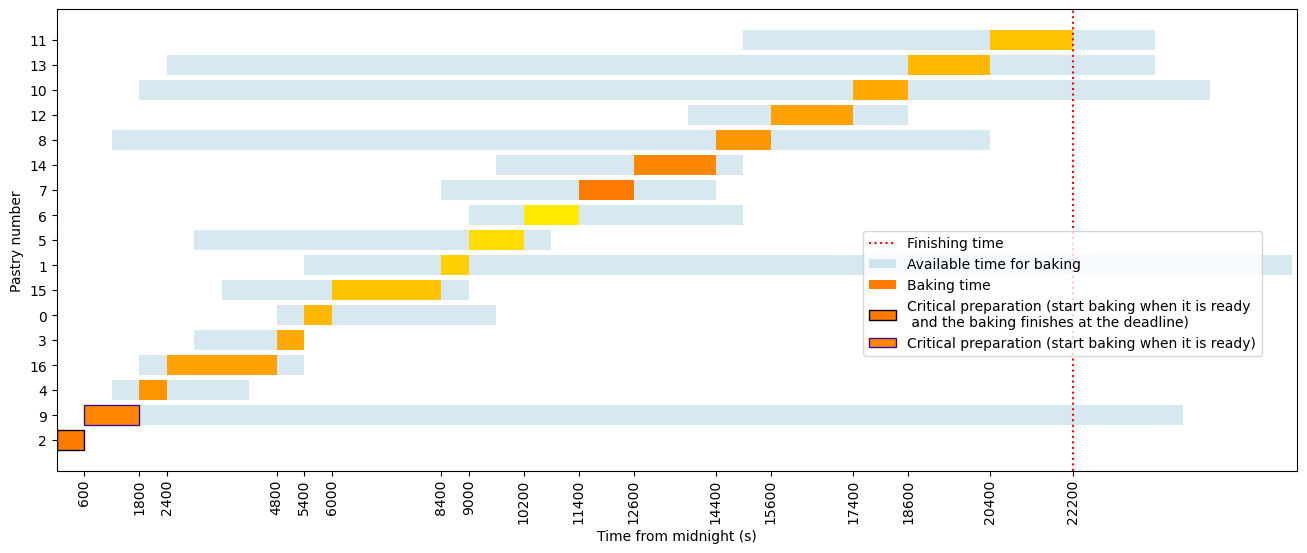

In [42]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

temp = dict()
l = list(retval.keys())
for i in range(17):
    temp[f"s_{i}"] = (retval[l[i]], vals[i][3])

schedule = dict(sorted(temp.items(), key=lambda item: item[1]))

ordered_idx = list(df.index)
y_lab = [0]*len(ordered_idx)
for i in range(len(ordered_idx)):
    y_lab[i] = int(ordered_idx[i][2:])
y_lab


fig, ax = plt.subplots(figsize=(16,6))

ax.barh(range(17), df.dln - df.pre, left=df.pre, color='#3890bc', label='Available time for baking', alpha=0.2)
ax.barh(range(17), df.bak, left=df.starting_time, color=df.color, label='Baking time')

for i in range(17):
    if df.starting_time[i] == df.pre[i] and df.starting_time[i] + df.bak[i] == df.dln[i]:
        ax.barh(i, df.bak[i], left=df.starting_time[i], color=df.color[i], edgecolor='black', label='Critical preparation (start baking when it is ready\n and the baking finishes at the deadline)')
    elif df.starting_time[i] == df.pre[i]:
        ax.barh(i, df.bak[i], left=df.starting_time[i], color=df.color[i], edgecolor='#3a0ca3', label='Critical preparation (start baking when it is ready)')


ax.set_xticks(df.end)
ax.set_yticks(range(17))
ax.set_yticklabels(y_lab)
ax.set_xlabel('Time from midnight (s)')
ax.set_ylabel('Pastry number')
ax.set_xbound(0, df.dln.max()+100)
ax.tick_params(axis='x',labelsize= 10, pad = 2, rotation = 90)

ax.axvline(prob.objective.value(), color='red', linestyle='dotted', label='Finishing time')

handles, labels = ax.get_legend_handles_labels()
legend_handles = [Patch(facecolor='#3890bc', alpha=0.2), *handles]
legend_labels = ['Available time for preparation', *labels]
ax.legend(loc=(0.65, 0.25))

plt.show()

